In [34]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [35]:
#import data
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv(r"D:\USTH\DLR\data\Alldata.csv")
df = df.interpolate(method='quadratic')
date_time = pd.to_datetime(df.pop('datetime'), format='%m/%d/%Y %H:%M')

df['Wind'] = df.pop('Wind1')/3.6
print(df.head())

   temp  WinDir  GHI      Wind
0  26.0    60.0  0.0  7.694444
1  26.0    50.0  0.0  7.416667
2  26.0    60.0  0.0  7.194444
3  26.0    50.0  0.0  8.194444
4  25.8    57.0  0.0  8.138889


[    0     1     2 ... 13522 13523 13524] [0.00000000e+00 3.24092635e-01 6.48185271e-01 ... 4.38238061e+03
 4.38270471e+03 4.38302880e+03]


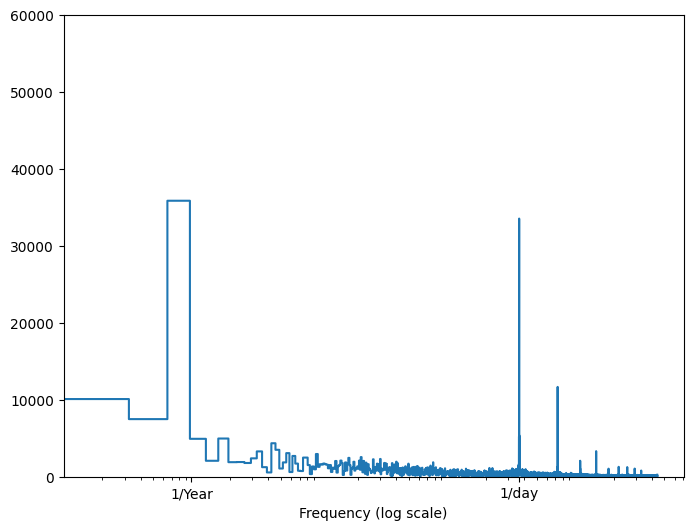

In [36]:
#fourier analysis
fft = tf.signal.rfft(df['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset

print(f_per_dataset,f_per_year)
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

plt.show()

In [37]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))

In [38]:
#split data, last month for test
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):(n-744)]
test_df = df[(n-744):]

num_features = df.shape[1]

In [39]:
#normalise data + plot  
train_mean = train_df.mean()
train_std = train_df.std()

cursor_mean = train_mean
cursor_std = train_std

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [40]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)


  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


In [41]:
WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Wind', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.plot(self.label_indices, labels[n, :, label_col_index], color = 'green')
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [42]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=24,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [43]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [44]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [45]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Text(0.5, 1.0, 'Time of day signal')

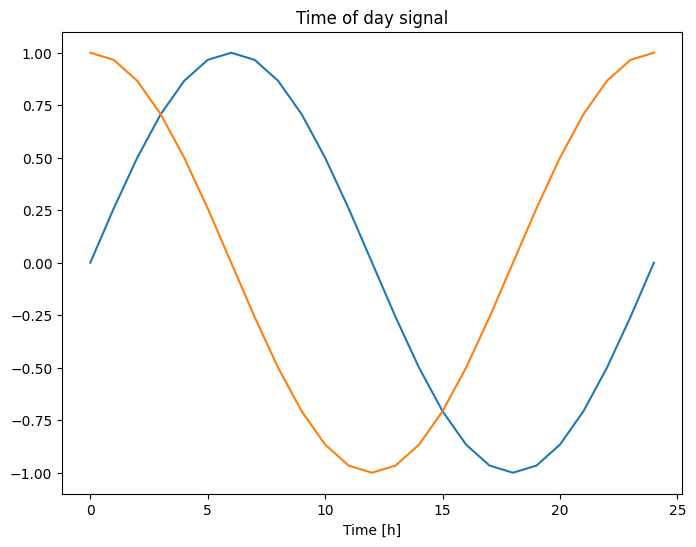

In [46]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [47]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (24, 24, 8)
Labels shape (batch, time, features): (24, 24, 8)


In [48]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

In [49]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

194/194 [==============================] - 0s 1ms/step - loss: 0.2358 - mean_squared_error: 0.2070


In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [51]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

195/195 [==============================] - 0s 736us/step - loss: 0.1167 - mean_absolute_error: 0.1615


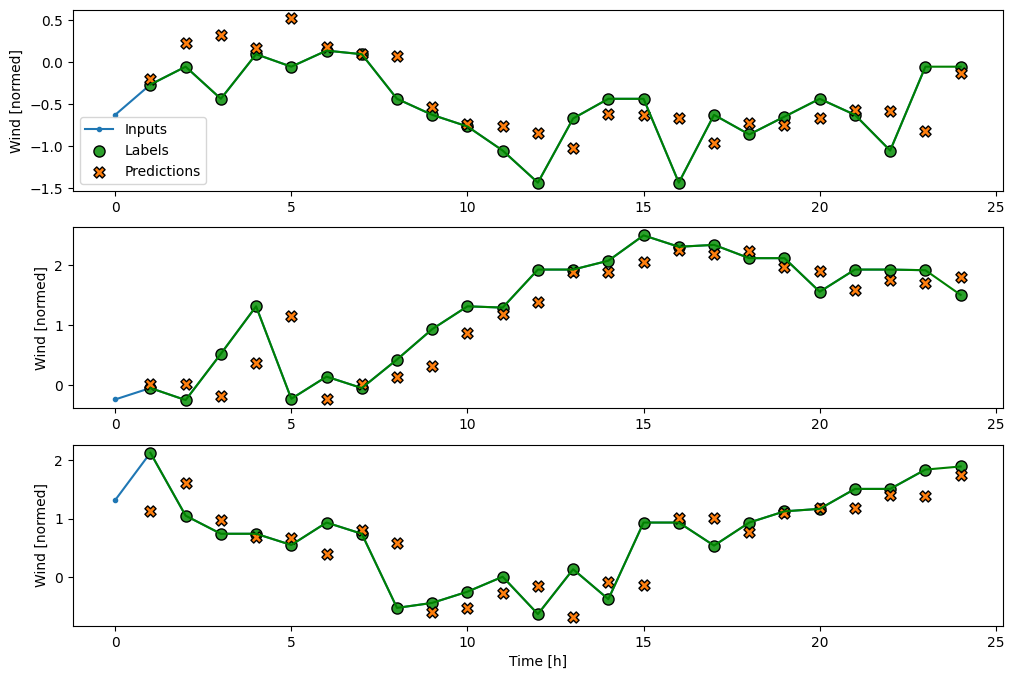

In [52]:
wide_window.plot(dense)

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [54]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

195/195 [==============================] - 0s 764us/step - loss: 0.1163 - mean_absolute_error: 0.1619


In [55]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [56]:
%%time
wide_window = WindowGenerator(
    input_width=72, label_width=72, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(48, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)



192/192 [==============================] - 1s 5ms/step - loss: 0.1115 - mean_absolute_error: 0.1607
CPU times: total: 2min 23s
Wall time: 12min 53s


In [57]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [58]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

192/192 [==============================] - 1s 5ms/step - loss: 0.1113 - mean_absolute_error: 0.1527

CPU times: total: 2min 8s
Wall time: 9min 23s


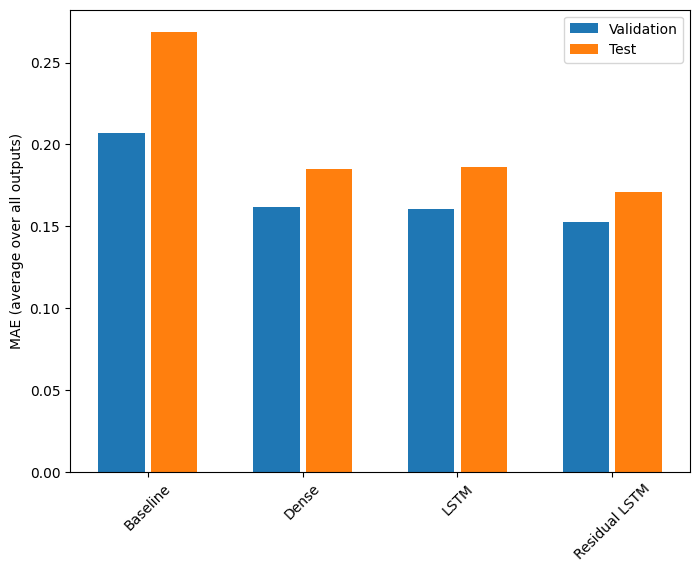

In [59]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [60]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.2688
Dense          : 0.1846
LSTM           : 0.1859
Residual LSTM  : 0.1708


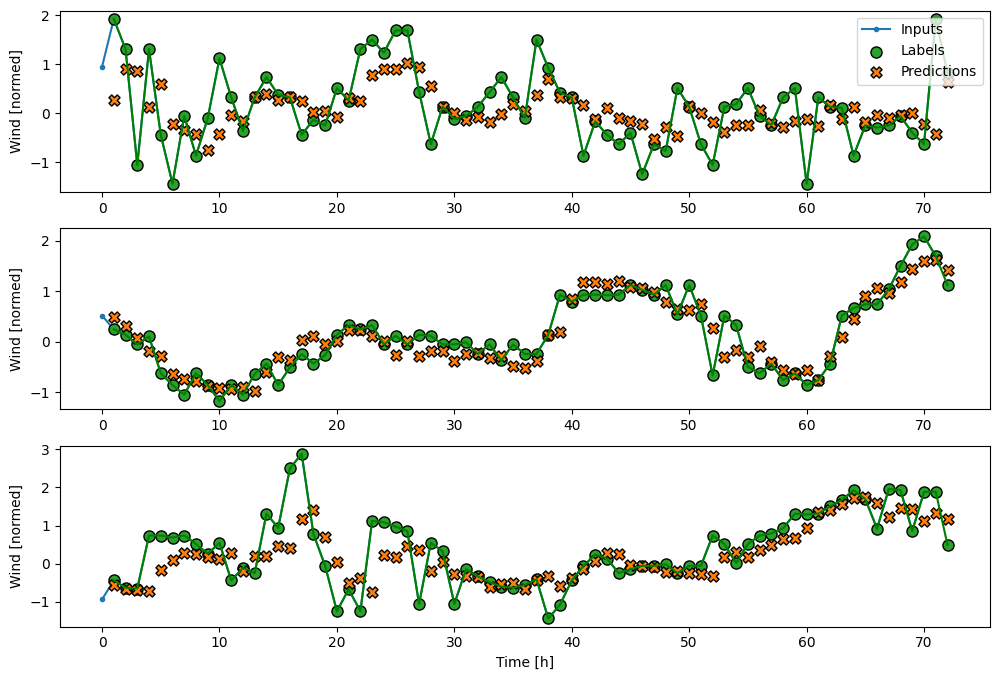

In [61]:
wide_window.plot(lstm_model)

In [62]:
print(cursor_std, cursor_mean)

temp          3.162485
WinDir      122.907778
GHI         294.061072
Wind          2.619063
Day cos       0.707154
Day sin       0.707093
Year cos      0.702592
Year sin      0.699960
dtype: float64 temp         27.789921
WinDir      159.958970
GHI         217.241065
Wind          3.753534
Day cos      -0.000045
Day sin       0.000339
Year cos      0.013018
Year sin      0.127656
dtype: float64


In [63]:
inputs, labels= wide_window.example


plot_col_index = wide_window.column_indices['temp']

label_col_index = plot_col_index
#print(inputs)
a = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

in_np = a.numpy()
in_np = in_np*cursor_std['temp'] + cursor_mean['temp']
predictions = lstm_model(inputs)

u = predictions[1, :, label_col_index]

u_np = u.numpy()
u_np = u_np*cursor_std['temp'] + cursor_mean['temp']
df = pd.DataFrame(in_np,u_np)
#df.to_csv(r"D:\USTH\DLR\data\forecast data\temp1.csv")

In [64]:
plot_col_index = wide_window.column_indices['GHI']

label_col_index = plot_col_index
#print(inputs)
solar = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

solar_np = solar.numpy()
solar_np = solar_np*cursor_std['GHI'] + cursor_mean['GHI']
predictions = lstm_model(inputs)

u_solar = predictions[1, :, label_col_index]

u_solar_np = u_solar.numpy()
u_solar_np = u_solar_np*cursor_std['GHI'] + cursor_mean['GHI']
print(np.size(in_np),np.size(u_np),np.size(solar_np),np.size(u_solar_np))
df = pd.DataFrame(solar_np,u_solar_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\GHI1.csv")

72 72 72 72


,0
169.375763,449.0
5.310684,0.0
-0.287369,0.0
0.097015,0.0
4.155945,0.0


In [65]:
plot_col_index = wide_window.column_indices['Wind']

label_col_index = plot_col_index
#print(inputs)
wind = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

wind_np = wind.numpy()
wind_np = wind_np*cursor_std['Wind'] + cursor_mean['Wind']
predictions = lstm_model(inputs)

u_wind = predictions[1, :, label_col_index]

u_wind_np = u_wind.numpy()
u_wind_np = u_wind_np*cursor_std['Wind'] + cursor_mean['Wind']
df = pd.DataFrame(wind_np,u_wind_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\Wind1.csv")

,0
5.013061,5.111111
4.577349,4.388889
3.945213,4.111111
3.273324,3.611111
3.026964,4.027778


In [66]:
plot_col_index = wide_window.column_indices['WinDir']

label_col_index = plot_col_index
#print(inputs)
windir = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

windir_np = windir.numpy()
windir_np = windir_np*cursor_std['WinDir'] + cursor_mean['WinDir']
predictions = lstm_model(inputs)

u_windir = predictions[1, :, label_col_index]

u_windir_np = u_windir.numpy()
u_windir_np = u_windir_np*cursor_std['WinDir'] + cursor_mean['WinDir']
df = pd.DataFrame(windir_np,u_windir_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\Windir1.csv")

,0
91.149841,60.0
39.217140,57.0
25.933548,50.0
47.780663,50.0
88.065300,50.0


Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

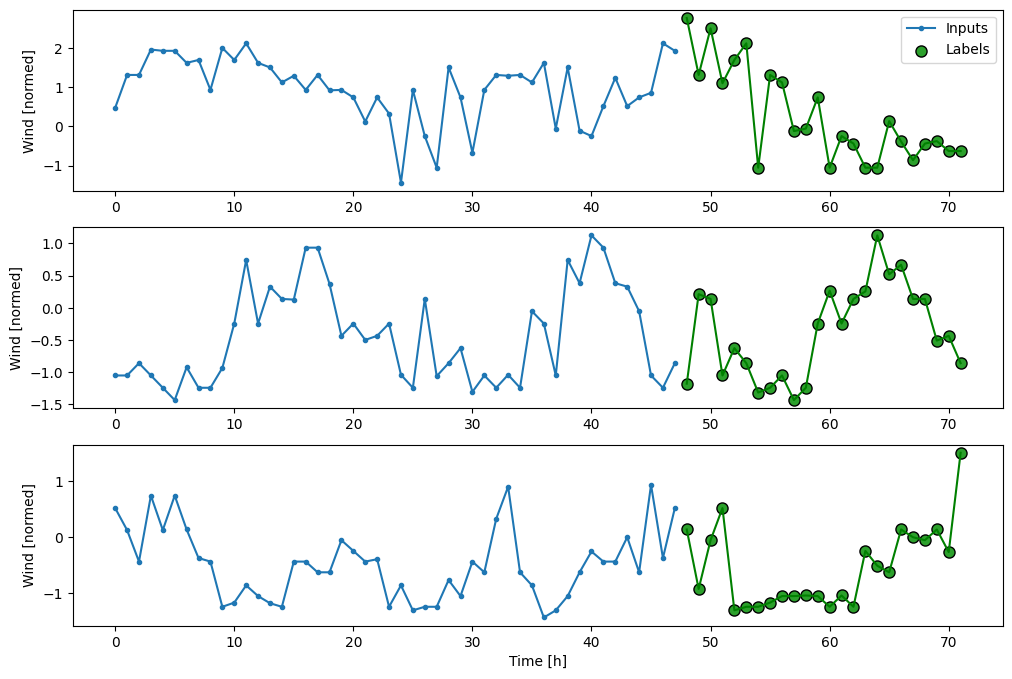

In [67]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=48,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

192/192 [==============================] - 0s 637us/step - loss: 1.2399 - mean_absolute_error: 0.7298


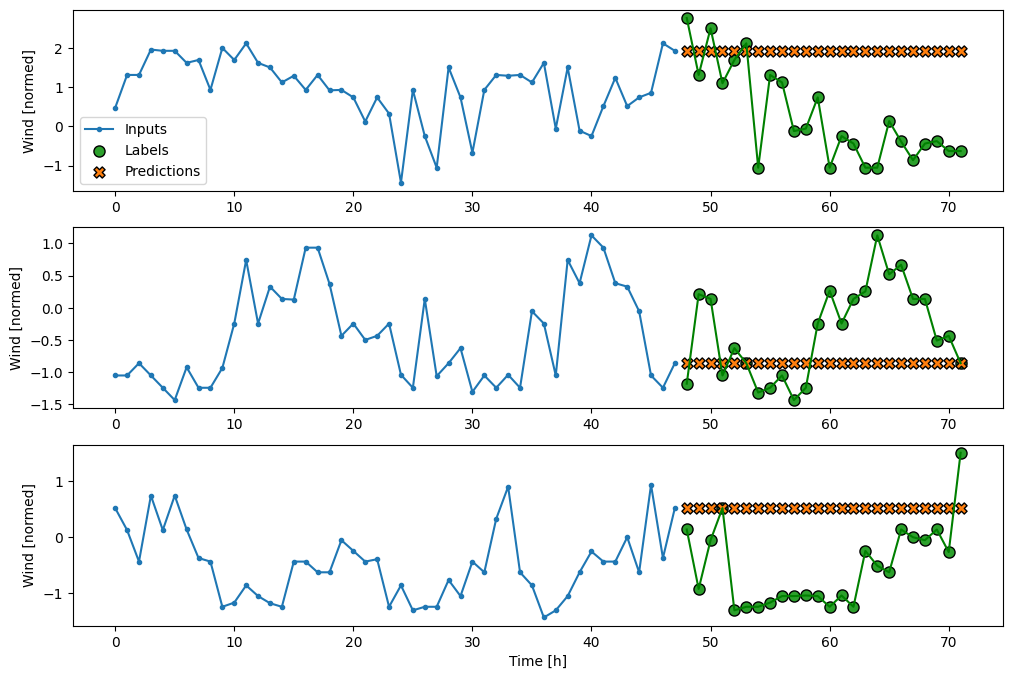

In [68]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

193/193 [==============================] - 0s 628us/step - loss: 0.2905 - mean_absolute_error: 0.2316


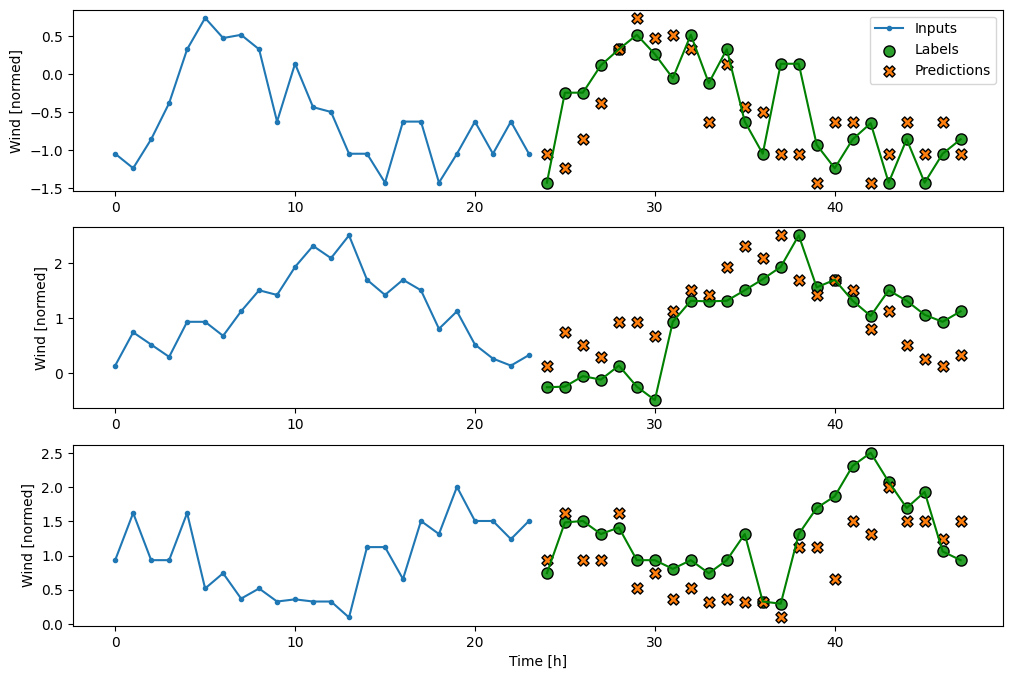

In [69]:
OUT_STEPS = 24
multi_window1 = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window1.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(repeat_baseline)

192/192 [==============================] - 0s 680us/step - loss: 0.2247 - mean_absolute_error: 0.2554


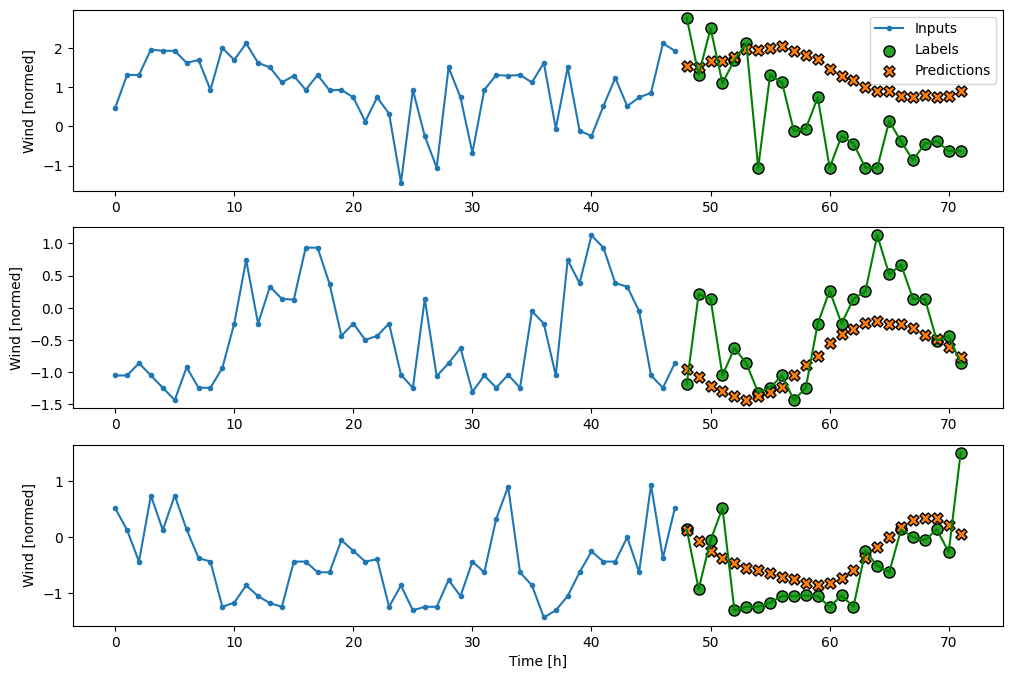

In [70]:
#single shot
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

192/192 [==============================] - 0s 792us/step - loss: 0.1833 - mean_absolute_error: 0.2185


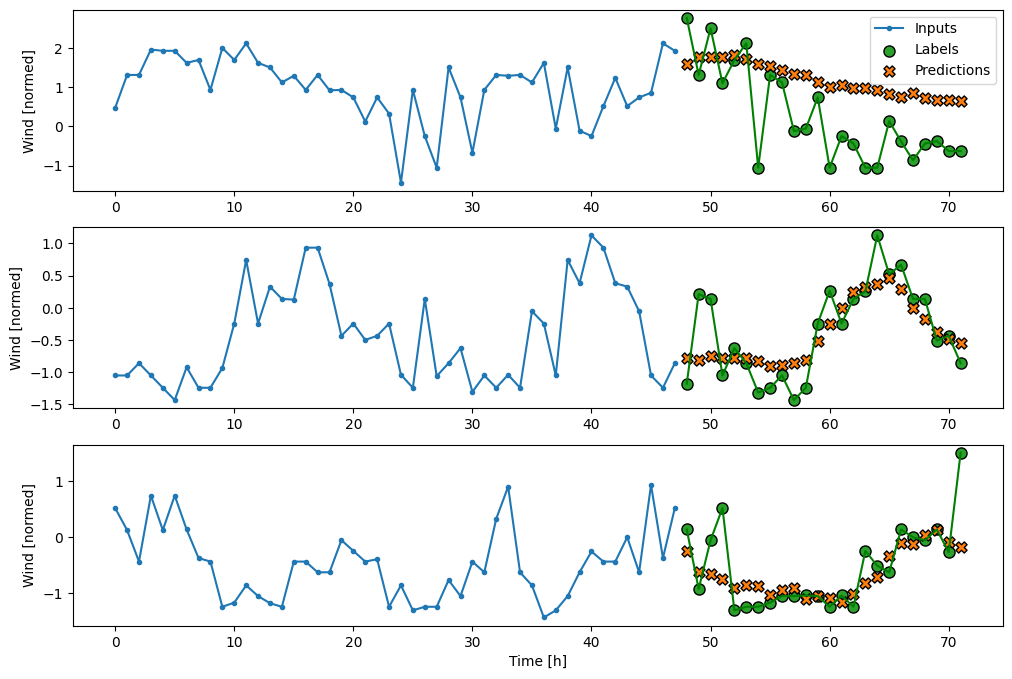

In [71]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

192/192 [==============================] - 1s 3ms/step - loss: 0.1931 - mean_absolute_error: 0.2401


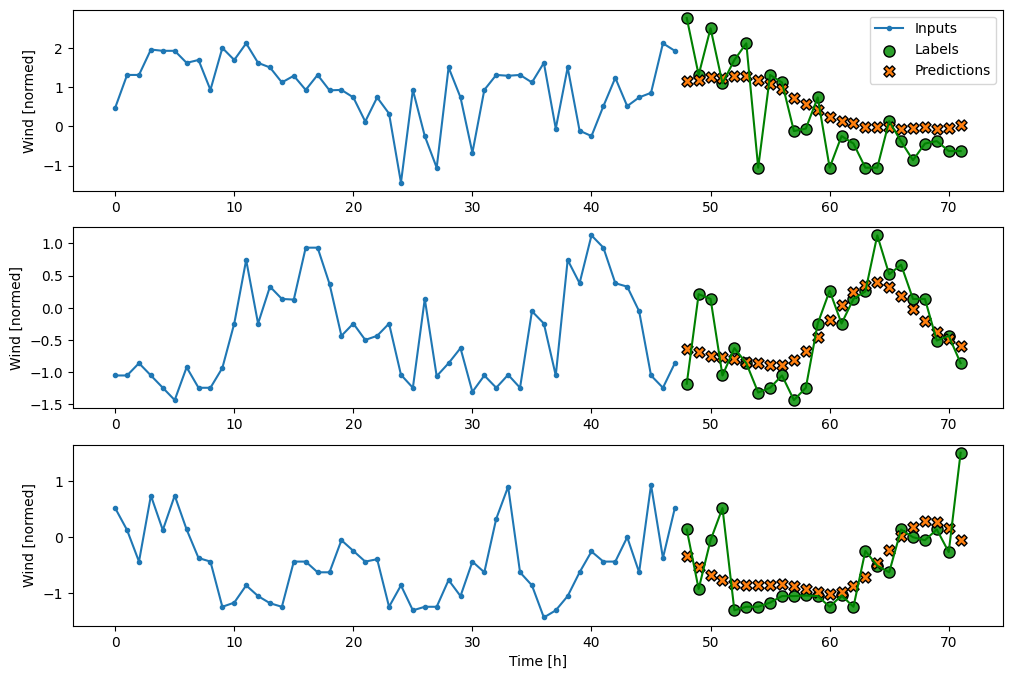

In [72]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [73]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [74]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [75]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [76]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

192/192 [==============================] - 1s 3ms/step - loss: 0.1985 - mean_absolute_error: 0.2470


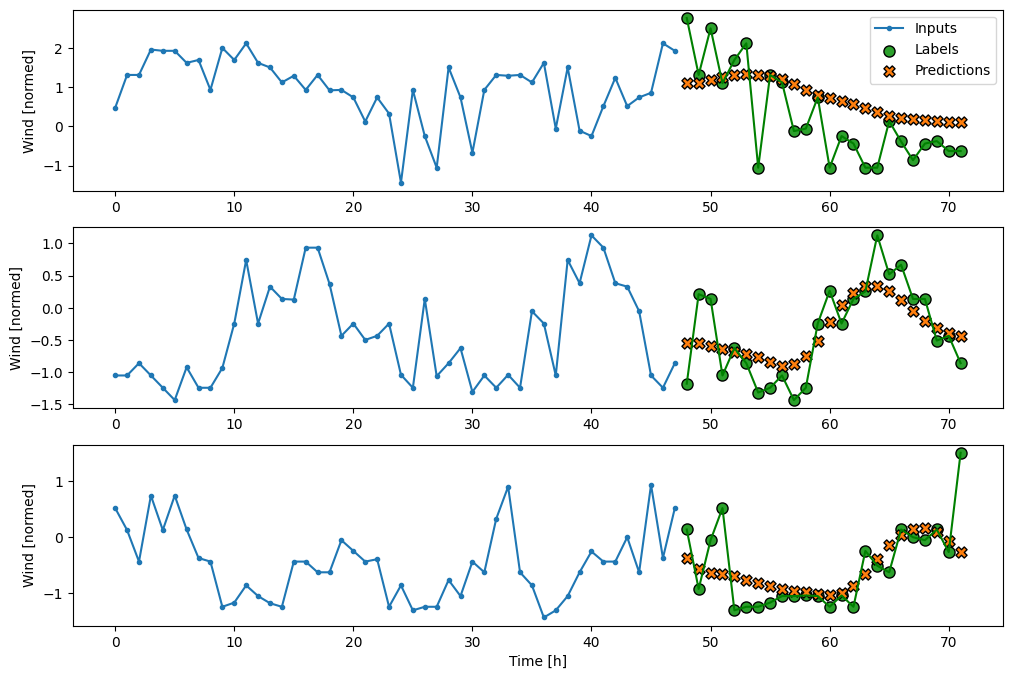

In [77]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

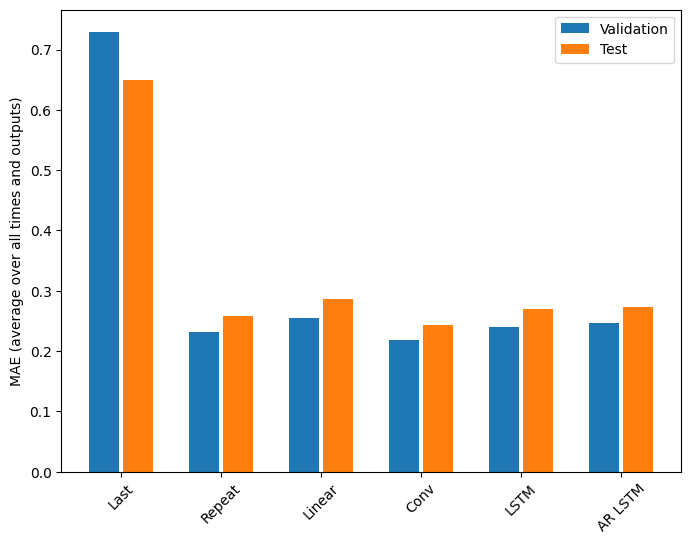

In [78]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [79]:
for name,value in multi_performance.items():
      print(f'{name:15s}: {value[1]:0.4f}')


Last           : 0.6487
Repeat         : 0.2574
Linear         : 0.2864
Conv           : 0.2440
LSTM           : 0.2701
AR LSTM        : 0.2734


In [ ]:
inputs, labels= multi_window.example


plot_col_index = multi_window.column_indices['temp']

label_col_index = plot_col_index
#print(inputs)
a = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

in_np = a.numpy()
in_np = in_np*cursor_std['temp'] + cursor_mean['temp']
predictions = lstm_model(inputs)

u = predictions[1, :, label_col_index]

u_np = u.numpy()
u_np = u_np*cursor_std['temp'] + cursor_mean['temp']
df = pd.DataFrame(in_np,u_np)
#df.to_csv(r"D:\USTH\DLR\data\forecast data\temp1.csv")


In [ ]:
plot_col_index = wide_window.column_indices['GHI']

label_col_index = plot_col_index
#print(inputs)
solar = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

solar_np = solar.numpy()
solar_np = solar_np*cursor_std['GHI'] + cursor_mean['GHI']
predictions = lstm_model(inputs)

u_solar = predictions[1, :, label_col_index]

u_solar_np = u_solar.numpy()
u_solar_np = u_solar_np*cursor_std['GHI'] + cursor_mean['GHI']
print(np.size(in_np),np.size(u_np),np.size(solar_np),np.size(u_solar_np))
df = pd.DataFrame(solar_np,u_solar_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\GHI1.csv")

In [ ]:
plot_col_index = wide_window.column_indices['Wind']

label_col_index = plot_col_index
#print(inputs)
wind = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

wind_np = wind.numpy()
wind_np = wind_np*cursor_std['Wind'] + cursor_mean['Wind']
predictions = lstm_model(inputs)

u_wind = predictions[1, :, label_col_index]

u_wind_np = u_wind.numpy()
u_wind_np = u_wind_np*cursor_std['Wind'] + cursor_mean['Wind']
df = pd.DataFrame(wind_np,u_wind_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\Wind1.csv")

In [ ]:
plot_col_index = wide_window.column_indices['WinDir']

label_col_index = plot_col_index
#print(inputs)
windir = inputs[1, :, label_col_index]
#t = labels[1, :, label_col_index]

windir_np = windir.numpy()
windir_np = windir_np*cursor_std['WinDir'] + cursor_mean['WinDir']
predictions = lstm_model(inputs)

u_windir = predictions[1, :, label_col_index]

u_windir_np = u_windir.numpy()
u_windir_np = u_windir_np*cursor_std['WinDir'] + cursor_mean['WinDir']
df = pd.DataFrame(windir_np,u_windir_np)
df.head()
#df.to_csv(r"D:\USTH\DLR\data\forecast data\Windir1.csv")